# Modeling (Model and iNterpretation)
### Modeling Outline

* Metric to use
* Experimenting with a First Model
* Model Selection 
* Building a Custom Pipeline
* Model Tuning & GridSearch
* Feature Importance
* Confusion Matrix Analysis

In [24]:
# Import Statements
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaseEnsemble
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, make_scorer, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, auc, confusion_matrix, classification_report, recall_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

## Metric to use: Recall

Recall would be a better metric for this dataset because with churn rate, we can implement more customer retention strategies, and misidentifying someone as 'exited' and hitting them with a strategy to keep them engaged would be more beneficial than missing someone who exited and not hitting them with a strategy to keep them subscribed to the service. 

## Import Training Data

(From saved CSV during EDA)

In [25]:
df_train = pd.read_csv('/Users/hasan/Desktop/Muhammad Phase 3 Project/Data/training_set.csv', index_col=0)

df_train.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
2682,DC,55,510,354-5058,yes,no,0,106.1,77,18.04,...,100,10.50,96.4,92,4.34,12.9,3,3.48,0,False
3304,IL,71,510,330-7137,yes,no,0,186.1,114,31.64,...,140,16.88,206.5,80,9.29,13.8,5,3.73,4,True
757,UT,112,415,358-5953,no,no,0,115.8,108,19.69,...,111,20.68,184.6,78,8.31,13.1,5,3.54,1,False
2402,NY,77,415,388-9285,no,yes,33,143.0,101,24.31,...,102,18.04,104.9,120,4.72,15.3,4,4.13,5,True
792,NV,69,510,397-6789,yes,yes,33,271.5,98,46.16,...,102,21.54,165.4,85,7.44,8.2,2,2.21,1,True


In [5]:
df_train.shape

(2999, 21)

In [6]:
df_train.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 2682 to 1061
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2999 non-null   object 
 1   account length          2999 non-null   int64  
 2   area code               2999 non-null   int64  
 3   phone number            2999 non-null   object 
 4   international plan      2999 non-null   object 
 5   voice mail plan         2999 non-null   object 
 6   number vmail messages   2999 non-null   int64  
 7   total day minutes       2999 non-null   float64
 8   total day calls         2999 non-null   int64  
 9   total day charge        2999 non-null   float64
 10  total eve minutes       2999 non-null   float64
 11  total eve calls         2999 non-null   int64  
 12  total eve charge        2999 non-null   float64
 13  total night minutes     2999 non-null   float64
 14  total night calls       2999 non-null

In [6]:
df_train['churn'].value_counts()

False    2569
True      430
Name: churn, dtype: int64

## Build an Initial Model

AKA sanity check. This model is only built to see if it's possible to build a model using this dataset.

In [26]:
# Functions
def transform_df(df):
    
    """
    Transforms yes and no values in certain columns of the df to 1s and 0s, respectively. 
    Returns the dataframe.
    """
    
    df['international plan'] = df['international plan'].apply(lambda x: 1 if x.lower() == 'yes' else 0)
    df['voice mail plan'] = df['voice mail plan'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

    return df


def plot_conf_matrix(y_true, y_pred):
    
    """
    Plots a prettier confusion matrix than matplotlib.
    """
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap=sns.color_palette('Blues_d'), fmt='0.5g', annot_kws={"size": 16})
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.ylim([0,2])
    plt.show()

In [27]:
features_to_use = ['account length', 'international plan', 'voice mail plan', 'number vmail messages',
                   'total day charge', 'total eve charge', 'total night charge', 'total intl charge',
                   'customer service calls']
target = ['churn']

In [28]:
df_train_transformed = transform_df(df_train)
df_train_transformed.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
2682,DC,55,510,354-5058,1,0,0,106.1,77,18.04,...,100,10.50,96.4,92,4.34,12.9,3,3.48,0,False
3304,IL,71,510,330-7137,1,0,0,186.1,114,31.64,...,140,16.88,206.5,80,9.29,13.8,5,3.73,4,True
757,UT,112,415,358-5953,0,0,0,115.8,108,19.69,...,111,20.68,184.6,78,8.31,13.1,5,3.54,1,False
2402,NY,77,415,388-9285,0,1,33,143.0,101,24.31,...,102,18.04,104.9,120,4.72,15.3,4,4.13,5,True
792,NV,69,510,397-6789,1,1,33,271.5,98,46.16,...,102,21.54,165.4,85,7.44,8.2,2,2.21,1,True


In [11]:
X = df_train_transformed[features_to_use]
y = df_train_transformed[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)
X_train.shape, X_test.shape

((2249, 9), (750, 9))

In [29]:
# Use Smote to resample and fix the class imbalance problem
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

In [30]:
rf1 = RandomForestClassifier()
rf1.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [31]:
y_preds_test = rf1.predict(X_test)
y_preds_train = rf1.predict(X_train_resampled)

print('Training Recall:', recall_score(y_train_resampled, y_preds_train))
print('Testing Recall:', recall_score(y_test, y_preds_test))

Training Recall: 1.0
Testing Recall: 0.7553191489361702


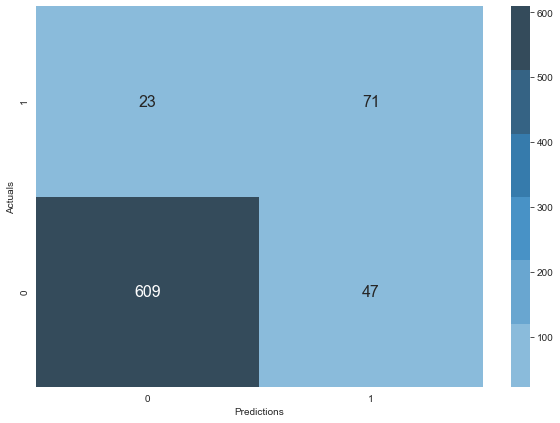

In [32]:
plot_conf_matrix(y_test, y_preds_test)
# We want to reduce that 25 because those are our False Negatives (people who churned that we missed)

# Logistic Regression Model

AUC: 0.6963868707836014


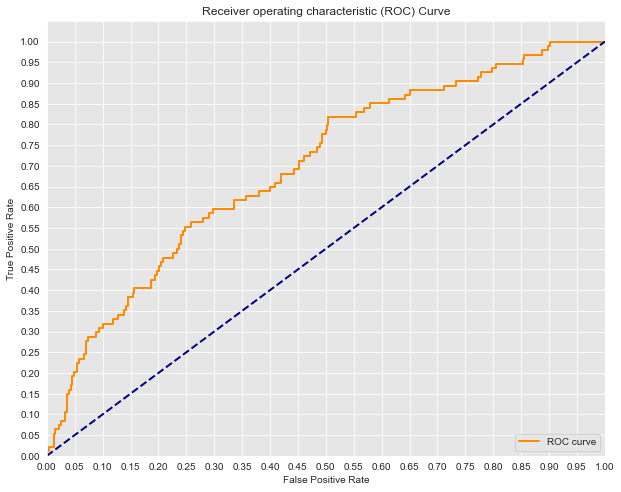

In [20]:
# Initial Model #what does the solver indicate?
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC

print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw=lw, label='ROC curve')
plt.plot([0,1], [0,1], color = 'navy', lw=lw, linestyle ='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [76]:
y_pred = logreg.predict(X_test)

In [77]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[632,  24],
       [ 80,  14]])

In [78]:
recall_score(y_test, y_pred)

0.14893617021276595

Logistic regression did'nt work as good as I thought it would, so I am not inlcuding it in further modeling process (might come back to it later)

# What is worse in terms of customer churn?

False positives would incorrectly predict that the customer is going to leave soon. False negatives would incorrectly predict that the customer is not going to leave soon. True negatives and true positives are the datapoints that were correctly predicted.

False negative would be worse than a false positive because it would mean that the reality of a customer cancelling would have been overlooked.

## Model Selection:
### Perform Test to Select Best Classifier

Model: RandomForestClassifier()
Training Recall: 1.0
Testing Recall: 0.7553191489361702


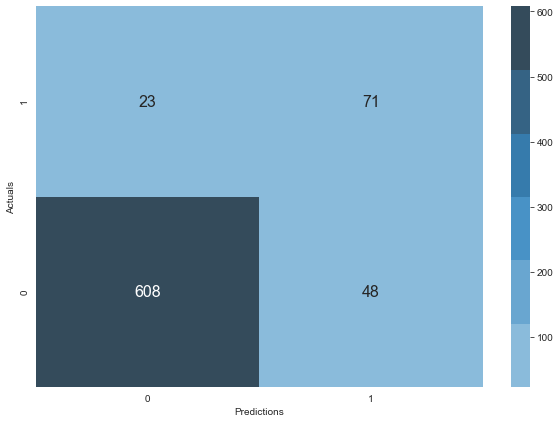


 ---------------------------------- 

Model: KNeighborsClassifier()
Training Recall: 0.9775222164140094
Testing Recall: 0.6276595744680851


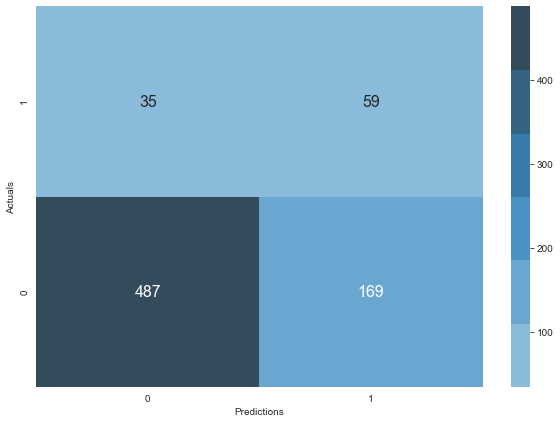


 ---------------------------------- 

Model: GradientBoostingClassifier()
Training Recall: 0.7673810768426556
Testing Recall: 0.7446808510638298


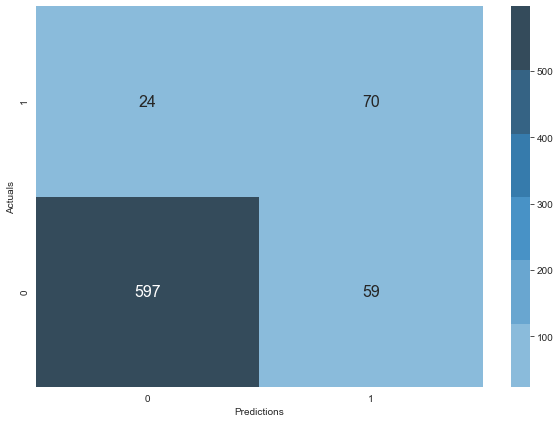


 ---------------------------------- 

Model: GaussianNB()
Training Recall: 0.7574490329325666
Testing Recall: 0.7978723404255319


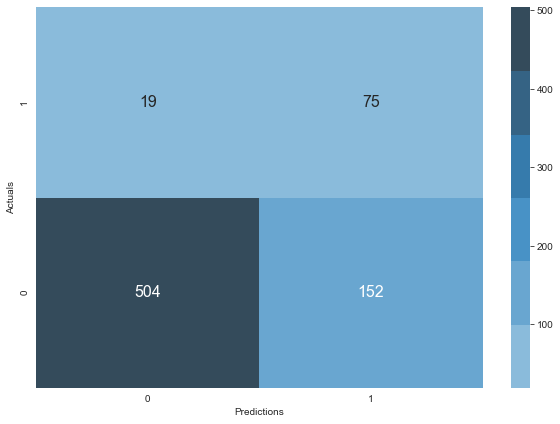


 ---------------------------------- 

Model: SVC()
Training Recall: 0.47412441191845267
Testing Recall: 0.5851063829787234


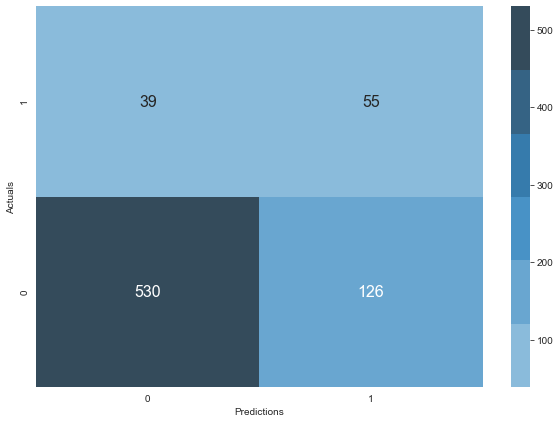


 ---------------------------------- 



In [33]:
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
gboost = GradientBoostingClassifier()
gbayes = GaussianNB()
svm = SVC()

models = [rf, knn, gboost, gbayes, svm]

for model in models:
    model.fit(X_train_resampled, y_train_resampled)
    y_preds_test = model.predict(X_test)
    y_preds_train = model.predict(X_train_resampled)
    print('Model:', model)
    print('Training Recall:', recall_score(y_train_resampled, y_preds_train))
    print('Testing Recall:', recall_score(y_test, y_preds_test))
    plot_conf_matrix(y_test, y_preds_test)
    print('\n ---------------------------------- \n')

**Notes:**

The best performing classifiers here were Gradient Boost, and Gaussian Naive Bayes. They both had the lowest False Negatives and the least overfitting. I would like to redo the KNN model with a scaler to see if that helps it perform better (distance is very much affected by the scales of the features). 

It is also important to note that I did not do any hypertuning yet, nor feature engineering. I am only checking initally which model might do the best with this dataset.

New KNN Model:
Training Recall: 0.0
Testing Recall: 0.0


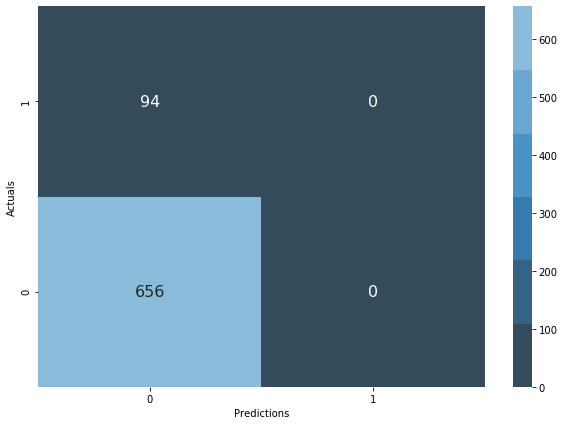

In [16]:
# Redo the KNN model with feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

knn.fit(X_train_scaled, y_train_resampled)

y_preds_test = model.predict(X_test_scaled)
y_preds_train = model.predict(X_train_scaled)
print('New KNN Model:')
print('Training Recall:', recall_score(y_train_resampled, y_preds_train))
print('Testing Recall:', recall_score(y_test, y_preds_test))
plot_conf_matrix(y_test, y_preds_test)

Not good. It just predicted everything as not churning. Therefore, I will proceed with Gradient Boosting.

## Set up the Pipeline 

**Steps**

1) Choose Columns (need to build a class for this)

2) Transform categorical columns and build features (need a custom class for this too)

3) Deal with class imbalance using SMOTE (imblearn's pipeline will only apply this step to training set)

4) Build model and predict (use existing sklearn methods)

In [34]:
# Functions to build features

def categorize_state(state):
    if state in ['AK', 'AZ', 'DC', 'HI', 'IA', 'IL', 'LA', 'NE', 'NM', 'RI', 'VA', 'WI', 'WV']:
        state = 1
    elif state in ['AL', 'CO', 'FL', 'ID', 'IN', 'KY', 'MO', 'NC', 'ND', 'NH', 'OH', 'OR', 'SD', 'TN', 'VT', 'WY']:
        state = 2
    elif state in ['CT', 'DE', 'GA', 'KS', 'MA', 'MN', 'MS', 'MT', 'NV', 'NY', 'OK', 'UT']:
        state = 3
    else:
        state = 4
    return state


def build_features(X):
    X['total charge'] = X['total day charge'] + X['total eve charge'] + X['total night charge'] + X['total intl charge']
    X['total minutes'] = X['total day minutes'] + X['total eve minutes'] + X['total night minutes'] + X['total intl minutes']
    X['total calls'] = X['total day calls'] + X['total eve calls'] + X['total night calls'] + X['total intl calls']
    X['avg minutes per domestic call'] = (X['total minutes'] - X['total intl minutes']) / (X['total calls'] - X['total intl calls'])
    X['competition'] = X['state'].apply(categorize_state)
    return X

In [35]:
# Build custom classes to build into the pipeline

class SelectColumnsTransformer(BaseEstimator):
    
    def __init__(self, columns=None):
        self.columns = columns
        
    def transform(self, X, **transform_params):
        cpy_df = X[self.columns].copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self
    
    
class Transform_Categorical(BaseEstimator):
    
    def transform(self, X, y=None, **transform_params):
        try:
            X['international plan'] = X['international plan'].apply(self.yes_no_func)
            X['voice mail plan'] = X['voice mail plan'].apply(self.yes_no_func)
        except:
            pass
        return X

    def fit(self, X, y=None, **fit_params):
        return self
    
    @staticmethod
    def yes_no_func(x):
        return 1 if x.lower() == 'yes' else 0

In [36]:
df_with_features = build_features(df_train)
df_with_features.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total charge,total minutes,total calls,avg minutes per domestic call,competition
2682,DC,55,510,354-5058,1,0,0,106.1,77,18.04,...,12.9,3,3.48,0,False,36.36,338.9,272,1.211896,1
3304,IL,71,510,330-7137,1,0,0,186.1,114,31.64,...,13.8,5,3.73,4,True,61.54,605.0,339,1.770060,1
757,UT,112,415,358-5953,0,0,0,115.8,108,19.69,...,13.1,5,3.54,1,False,52.22,556.8,302,1.830640,3
2402,NY,77,415,388-9285,0,1,33,143.0,101,24.31,...,15.3,4,4.13,5,True,51.20,475.4,327,1.424458,3
792,NV,69,510,397-6789,1,1,33,271.5,98,46.16,...,8.2,2,2.21,1,True,77.35,698.5,287,2.422105,3


In [37]:
features_to_use = ['account length', 'international plan', 'voice mail plan', 'number vmail messages',
                   'total charge', 'customer service calls', 'competition',
                   'avg minutes per domestic call', 'total calls', 'total minutes']
target = ['churn']

In [38]:
pipeline = Pipeline(steps= [
                    ("ColumnTransformer", SelectColumnsTransformer(columns=features_to_use)),
                    ("TransformCategorical", Transform_Categorical()),
                    ("SMOTE", SMOTE()),
                    ("GradientBooster", GradientBoostingClassifier())
                    ])

In [39]:
X_train = df_with_features.drop(columns=['churn'])
y_train = df_with_features[target]

In [40]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('ColumnTransformer',
                 SelectColumnsTransformer(columns=['account length',
                                                   'international plan',
                                                   'voice mail plan',
                                                   'number vmail messages',
                                                   'total charge',
                                                   'customer service calls',
                                                   'competition',
                                                   'avg minutes per domestic '
                                                   'call',
                                                   'total calls',
                                                   'total minutes'])),
                ('TransformCategorical', Transform_Categorical()),
                ('SMOTE', SMOTE()),
                ('GradientBooster', GradientBoostingClassifier())])

In [41]:
# Bring in validation set to test
df_validation = pd.read_csv('/Users/hasan/Desktop/Muhammad Phase 3 Project/Data/validation_set.csv', index_col=0)
df_validation.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
2360,IN,68,415,386-9724,no,no,0,222.1,107,37.76,...,102,16.95,162.4,107,7.31,9.4,3,2.54,2,False
600,MI,102,510,336-4656,no,no,0,102.6,89,17.44,...,77,20.91,170.5,140,7.67,9.1,4,2.46,2,False
1501,AZ,72,510,407-9830,no,no,0,272.4,88,46.31,...,125,9.17,185.5,81,8.35,12.7,2,3.43,0,False
1114,TN,108,408,352-1127,no,yes,15,165.1,85,28.07,...,93,22.70,250.7,114,11.28,10.9,4,2.94,1,False
517,OK,52,408,389-4780,no,no,0,214.7,68,36.50,...,138,13.48,123.4,114,5.55,9.4,4,2.54,2,False


In [42]:
df_valid_transformed = build_features(df_validation)
X_valid = df_valid_transformed.drop(columns='churn')
y_valid = df_valid_transformed['churn']

In [43]:
pipeline.score(X_valid, y_valid)

0.9191616766467066

In [44]:
y_preds = pipeline.predict(X_valid)

0.7358490566037735
Confusion Matrix for Model Before Tuning


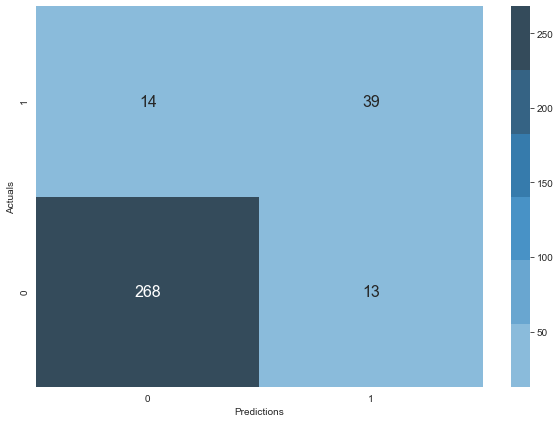

In [45]:
print(recall_score(y_valid, y_preds))
print('Confusion Matrix for Model Before Tuning')
plot_conf_matrix(y_valid, y_preds)

## Model Tuning & GridSearch

In [46]:
param_grid = {
            "ColumnTransformer__columns": [['account length', 'international plan', 'voice mail plan',
                                           'number vmail messages', 'total day minutes', 'total day calls',
                                           'total day charge', 'total eve minutes', 'total eve calls',
                                           'total eve charge', 'total night minutes', 'total night calls',
                                           'total night charge', 'total intl minutes', 'total intl calls',
                                           'total intl charge', 'customer service calls'],
                                          ['account length', 'international plan', 'voice mail plan',
                                           'number vmail messages', 'total day minutes', 'total day calls',
                                           'total day charge', 'total eve minutes', 'total eve calls',
                                           'total eve charge', 'total night minutes', 'total night calls',
                                           'total night charge', 'total intl minutes', 'total intl calls',
                                           'total intl charge', 'customer service calls', 'total charge', 
                                           'total minutes', 'total calls', 'avg minutes per domestic call',
                                           'competition']],
        "SMOTE__sampling_strategy": [1],
        "GradientBooster__loss": ['deviance', 'exponential'],
        "GradientBooster__n_estimators": [100, 150],
        "GradientBooster__max_depth": [3, 5],
        "GradientBooster__max_features": ['auto', 8, None]
}

In [47]:
# Warning! This takes a long time to run!
gs_pipeline = GridSearchCV(pipeline, param_grid=param_grid, verbose=2, scoring=make_scorer(recall_score))
gs_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] ColumnTransformer__columns=['account length', 'international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls'], GradientBooster__loss=deviance, GradientBooster__max_depth=3, GradientBooster__max_features=auto, GradientBooster__n_estimators=100, SMOTE__sampling_strategy=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ColumnTransformer__columns=['account length', 'international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls'], GradientBooster__loss=deviance, GradientBooster__max_depth=3, GradientBooster__max_features=auto, GradientBooster__n_estimators=100, SMOTE__sampling_strategy=1, total=   1.2s
[CV] ColumnTransformer__columns=['account length', 'international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls'], GradientBooster__loss=deviance, Gradie

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  ColumnTransformer__columns=['account length', 'international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls'], GradientBooster__loss=deviance, GradientBooster__max_depth=3, GradientBooster__max_features=auto, GradientBooster__n_estimators=100, SMOTE__sampling_strategy=1, total=   1.1s
[CV] ColumnTransformer__columns=['account length', 'international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls'], GradientBooster__loss=deviance, Gradie

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 10.1min finished


GridSearchCV(estimator=Pipeline(steps=[('ColumnTransformer',
                                        SelectColumnsTransformer(columns=['account '
                                                                          'length',
                                                                          'international '
                                                                          'plan',
                                                                          'voice '
                                                                          'mail '
                                                                          'plan',
                                                                          'number '
                                                                          'vmail '
                                                                          'messages',
                                                                          'total '
              

In [48]:
gs_pipeline.best_estimator_

Pipeline(steps=[('ColumnTransformer',
                 SelectColumnsTransformer(columns=['account length',
                                                   'international plan',
                                                   'voice mail plan',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
                                                   'total night charge',
                             

In [201]:
gs_pipeline.best_params_

{'ColumnTransformer__columns': ['account length',
  'international plan',
  'voice mail plan',
  'number vmail messages',
  'total day minutes',
  'total day calls',
  'total day charge',
  'total eve minutes',
  'total eve calls',
  'total eve charge',
  'total night minutes',
  'total night calls',
  'total night charge',
  'total intl minutes',
  'total intl calls',
  'total intl charge',
  'customer service calls',
  'total charge',
  'total minutes',
  'total calls',
  'avg minutes per domestic call',
  'competition'],
 'GradientBooster__loss': 'deviance',
 'GradientBooster__max_depth': 5,
 'GradientBooster__max_features': None,
 'GradientBooster__n_estimators': 100,
 'SMOTE__sampling_strategy': 1}

In [49]:
best_model = gs_pipeline.best_estimator_
y_validation_preds = best_model.predict(X_valid)
recall_score(y_valid, y_validation_preds)

0.8113207547169812

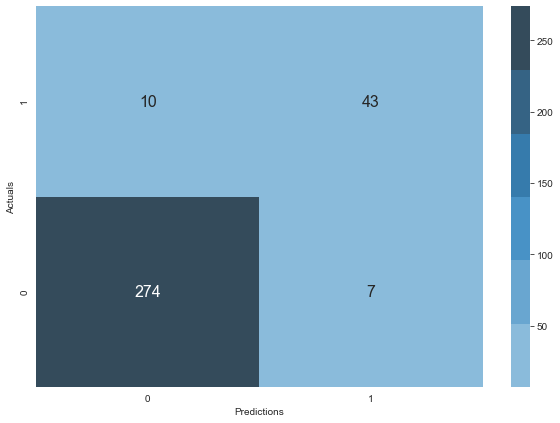

In [50]:
plot_conf_matrix(y_valid, y_validation_preds)

## Feature Importance

In [51]:
def plot_feature_importances(X, model):
    features = X.columns
    feat_imp_scores = model.feature_importances_
    plt.figure(figsize=(10, 8))
    plt.bar(features, feat_imp_scores, zorder=2, alpha=0.8)
    plt.grid(zorder=0)
    plt.xticks(rotation=90)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances of Model')
    plt.show()

In [52]:
best_model.steps[3][1].feature_importances_

array([0.00470472, 0.07711954, 0.07677286, 0.0739895 , 0.00390821,
       0.0039077 , 0.00378562, 0.00359029, 0.0041315 , 0.00598219,
       0.00694079, 0.00227017, 0.004495  , 0.01337627, 0.06294545,
       0.01990871, 0.17375492, 0.43061319, 0.00795038, 0.00437028,
       0.00478671, 0.01069598])

In [53]:
best_model.steps[0][1].columns

['account length',
 'international plan',
 'voice mail plan',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'total charge',
 'total minutes',
 'total calls',
 'avg minutes per domestic call',
 'competition']

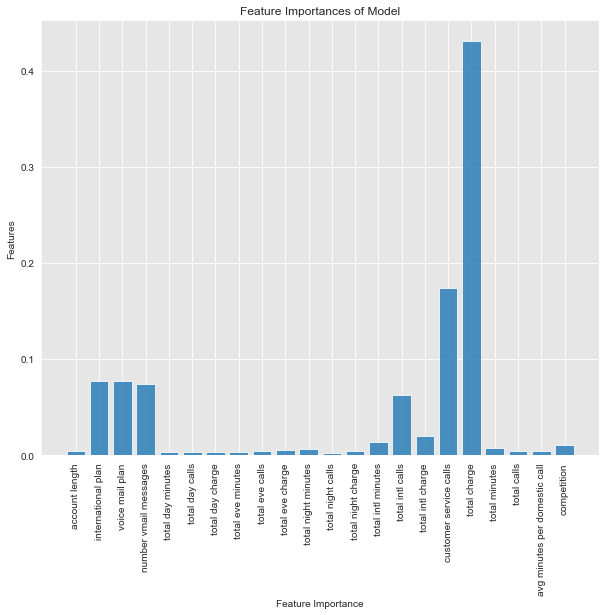

In [54]:
plot_feature_importances(X=best_model.steps[0][1], model=best_model.steps[3][1])

## New Model with Most Important Features

I will train a new model with just the top 8 features and test if these perform better or similar to our previous model to potentially save resources.

In [55]:
param_grid = {
            "ColumnTransformer__columns": [['total charge', 'customer service calls', 'number vmail messages',
                                          'voice mail plan', 'international plan', 'total intl calls',
                                           'total intl minutes', 'total intl charge']],
        "SMOTE__sampling_strategy": [1],
        "GradientBooster__n_estimators": [100, 150],
        "GradientBooster__max_depth": [3, 5],
        "GradientBooster__max_features": [None]
}

In [56]:
gs_pipeline = GridSearchCV(pipeline, param_grid=param_grid, verbose=2, scoring=make_scorer(recall_score))
gs_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] ColumnTransformer__columns=['total charge', 'customer service calls', 'number vmail messages', 'voice mail plan', 'international plan', 'total intl calls', 'total intl minutes', 'total intl charge'], GradientBooster__max_depth=3, GradientBooster__max_features=None, GradientBooster__n_estimators=100, SMOTE__sampling_strategy=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ColumnTransformer__columns=['total charge', 'customer service calls', 'number vmail messages', 'voice mail plan', 'international plan', 'total intl calls', 'total intl minutes', 'total intl charge'], GradientBooster__max_depth=3, GradientBooster__max_features=None, GradientBooster__n_estimators=100, SMOTE__sampling_strategy=1, total=   0.6s
[CV] ColumnTransformer__columns=['total charge', 'customer service calls', 'number vmail messages', 'voice mail plan', 'international plan', 'total intl calls', 'total intl minutes', 'total intl charge'], GradientBooster__max_depth=3, GradientBooster__max_features=None, GradientBooster__n_estimators=100, SMOTE__sampling_strategy=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  ColumnTransformer__columns=['total charge', 'customer service calls', 'number vmail messages', 'voice mail plan', 'international plan', 'total intl calls', 'total intl minutes', 'total intl charge'], GradientBooster__max_depth=3, GradientBooster__max_features=None, GradientBooster__n_estimators=100, SMOTE__sampling_strategy=1, total=   0.5s
[CV] ColumnTransformer__columns=['total charge', 'customer service calls', 'number vmail messages', 'voice mail plan', 'international plan', 'total intl calls', 'total intl minutes', 'total intl charge'], GradientBooster__max_depth=3, GradientBooster__max_features=None, GradientBooster__n_estimators=100, SMOTE__sampling_strategy=1 
[CV]  ColumnTransformer__columns=['total charge', 'customer service calls', 'number vmail messages', 'voice mail plan', 'international plan', 'total intl calls', 'total intl minutes', 'total intl charge'], GradientBooster__max_depth=3, GradientBooster__max_features=None, GradientBooster__n_estimators=100, SMOTE__sam

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   19.0s finished


GridSearchCV(estimator=Pipeline(steps=[('ColumnTransformer',
                                        SelectColumnsTransformer(columns=['account '
                                                                          'length',
                                                                          'international '
                                                                          'plan',
                                                                          'voice '
                                                                          'mail '
                                                                          'plan',
                                                                          'number '
                                                                          'vmail '
                                                                          'messages',
                                                                          'total '
              

In [57]:
gs_pipeline.best_params_

{'ColumnTransformer__columns': ['total charge',
  'customer service calls',
  'number vmail messages',
  'voice mail plan',
  'international plan',
  'total intl calls',
  'total intl minutes',
  'total intl charge'],
 'GradientBooster__max_depth': 5,
 'GradientBooster__max_features': None,
 'GradientBooster__n_estimators': 150,
 'SMOTE__sampling_strategy': 1}

In [58]:
best_model = gs_pipeline.best_estimator_
y_validation_preds = best_model.predict(X_valid)

Final Testing Recall: 0.8301886792452831


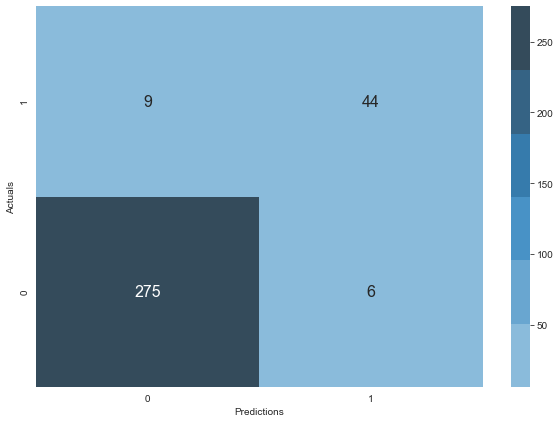

In [59]:
print('Final Testing Recall:', recall_score(y_valid, y_validation_preds))
plot_conf_matrix(y_valid, y_validation_preds)

Final Training Recall 0.9302325581395349


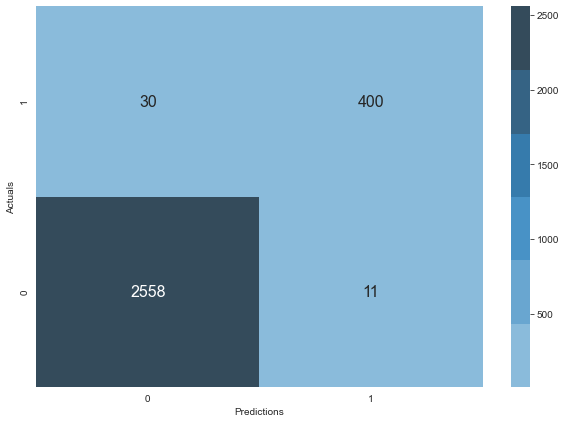

In [74]:
y_training_preds = best_model.predict(X_train)
print('Final Training Recall', recall_score(y_train, y_training_preds))
plot_conf_matrix(y_train, y_training_preds)

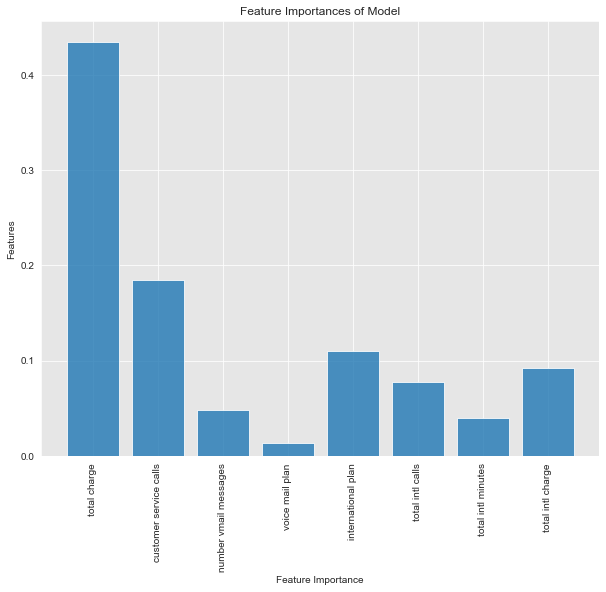

In [60]:
plot_feature_importances(X=best_model.steps[0][1], model=best_model.steps[3][1])

## Confusion Matrix & Cost Benefit Analysis

Let's say the cost of a False Positive is having to give a customer a discount of 50% off one month of free service when they were not actually going to churn. For this analysis we will say that the **cost of a FP = 25 USD per customer (-25)**.

Alternatively, the cost of a False Negative is losing that customer (and their monthly payment of 50 USD) and having to go out and get a new customer (customer acqusition cost of 50 USD). Therefore, we will say that the **cost of a FN = 100 USD per customer (-100)**.

The benefit of a True Positive is keeping that customer on and having them continue paying their 50 USD monthly payment, minus the 50% discount. **Benefit of TP = 25**

The **benefit of a True Negative = 0** since they were not going to churn and we predicted that, so we did not offer any discounts.

These costs and benefits are reflected in the function below. 

In [68]:
def cost_benefit_analysis(model, X_test, y_test):
    y_preds = model.predict(X_test)
    label_dict = {"TP":0, "FP": 0, "TN": 0, "FN": 0}
    for yt, yp in zip(y_test, y_preds):
        if yt==yp:
            if yt==1:
                label_dict["TP"] += 1
            else:
                label_dict["TN"] += 1
        else:
            if yp==1:
                label_dict["FP"] += 1
            else:
                label_dict["FN"] += 1
    cb_dict = {"TP": 25, "FP": -25, "TN": 0, "FN": -100}
    
    total = 0
    for key in label_dict.keys():
        total += cb_dict[key]*label_dict[key]
    return cb_dict, label_dict, total / sum(label_dict.values())

In [69]:
cb_dict, label_dict, expected_value = cost_benefit_analysis(best_model, X_valid, y_valid)

In [70]:
print(cb_dict, label_dict)

{'TP': 25, 'FP': -25, 'TN': 0, 'FN': -100} {'TP': 44, 'FP': 6, 'TN': 275, 'FN': 9}


In [71]:
# Put the cost benefit values in an array to plot
cb_array = [[cb_dict['TN']*label_dict['TN'],
            cb_dict['FP']*label_dict['FP']],
            [cb_dict['FN']*label_dict['FN'],
            cb_dict['TP']*label_dict['TP']]]
cb_array

[[0, -150], [-900, 1100]]

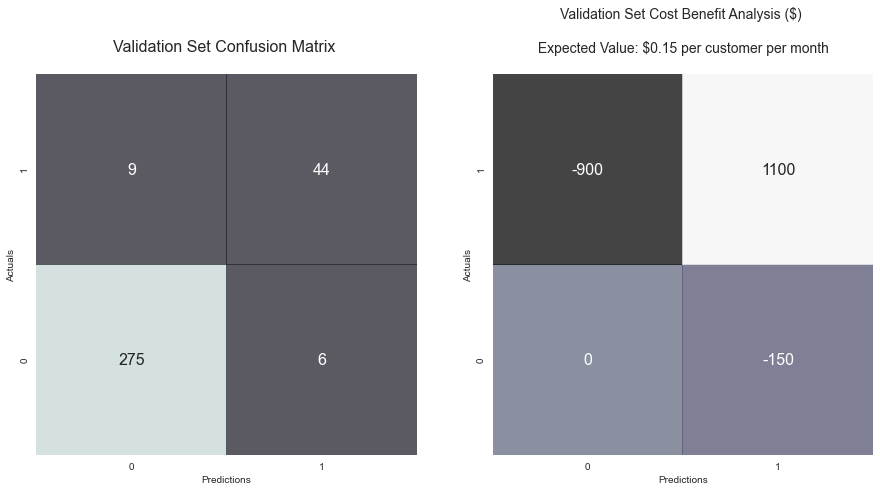

In [72]:
cm = confusion_matrix(y_valid, y_validation_preds)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

sns.heatmap(cm, annot=True, cmap=sns.color_palette('bone'), fmt='0.5g', cbar=False,
            annot_kws={'size': 16}, alpha=.7, ax=axes[0])

sns.heatmap(cb_array, annot=True, fmt='0.5g', cmap='bone', cbar=False,
            annot_kws={'size': 16}, alpha=.7, ax=axes[1])

plt.xlabel('Predictions')
plt.ylabel('Actuals')
axes[0].set_ylabel('Actuals')
axes[0].set_xlabel('Predictions')
axes[0].set_ylim([0,2])
axes[1].set_ylim([0,2])
axes[0].set_title('Validation Set Confusion Matrix \n', fontdict={'size': 16})
axes[1].set_title(f'Validation Set Cost Benefit Analysis ($) \n\n Expected Value: ${round(expected_value, 2)} per customer per month \n',
          fontdict={'size': 14})
plt.show()

Based on this cost benefit analysis, our expected value from this strategy is 52 cents per customer per month. That may not seem like much, but for millions of customers it would add up. The good news here is that with this model predicting churn, we are not LOSING money! We can see the breakdown of each cost and benefit multiplied by the number of TP, TN, FP, FNs on the confusion matrix above. 

## Conclusion

The final model had the following recall scores:

In [75]:
print('Validation Recall Score', round(recall_score(y_valid, y_validation_preds), 2))
print('Training Recall Score', round(recall_score(y_train, y_training_preds), 2))

Validation Recall Score 0.83
Training Recall Score 0.93


Since these recall scores are so close, we can assume the model is slightly overfit, but overall very good on recall. 
This model produced only 9 (2%) false negatives for the validation set. It produced only 1 (0.003%) false positive from the validation set, but if our customer retention strategy is to keep these customers engaged, it is not a bad thing to keep a customer engaged who is mispredicted as potentially exiting.

Finally, based on the cost benefit analysis of this model's predictive ability and the SyriaTel Communications strategy for customer retention, the expected value is 52 cents per customer per month. Over the course of a year and millions of customers nationwide, we can conclude that this strategy would make us a lot of money in the long run. 